In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import scipy.stats as st

import sklearn as sk
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import LinearSVC, SVC

from rba import RobustBiasAwareClassifier
from tcpr import TargetContrastivePessimisticClassifier

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import matplotlib.pyplot as plt
fontsize = 30
fontweight = 'bold'

In [3]:
# Data locations
data_dir = 'data/UCI-hdis/'
write_dir = 'viz/'

# Hospital location
hospX = 'Budapest, Hungary'
hospX_ = 'budapest'
hospZ = 'Long Beach, CA, USA'
hospZ_ = 'longbeach'

In [4]:
# Features
feats = ['age','sex','pain','BP','chol','fbs','ecg','maxhr','eiang','eist','slope','vessels','thal','diagnosis']

# Import and read data
X = pd.read_csv(data_dir + 'processed.hungarian.data', names=feats, na_values='?')
Z = pd.read_csv(data_dir + 'processed.virginia.data', names=feats, na_values='?')

# Map classes to binary
y = ((X['diagnosis'] > 0).astype(int)).values
u = ((Z['diagnosis'] > 0).astype(int)).values

In [5]:
X0 = X['age'].values
X1 = X['chol'].values

X0[np.isnan(X0)] = 0
X1[np.isnan(X1)] = 0

XX = np.vstack((X0, X1)).T

Z0 = Z['age'].values
Z1 = Z['chol'].values

Z0[np.isnan(Z0)] = 0
Z1[np.isnan(Z1)] = 0

ZZ = np.vstack((Z0, Z1)).T

In [6]:
XXy0 = np.vstack((X0[y==0][:168], X1[y==0][:168])).T
XXy1 = np.vstack((X0[y==1][18:], X1[y==1][18:])).T
XX = np.vstack((XXy0, XXy1))
yy = np.vstack((np.zeros((168,1), dtype='uint8'), np.ones((88,1), dtype='uint8')))[:,0]

In [7]:
# Generate grid
tx, ty = np.mgrid[20:80:.1, 50:650:1]
grid = np.c_[tx.ravel(), ty.ravel()]

# Range limits for features
age_lim = [20, 80]
chol_lim = [50, 650]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


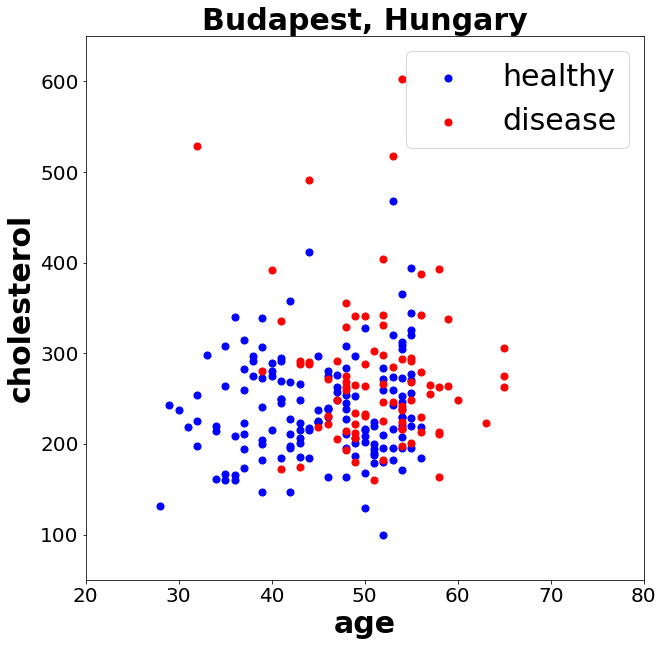

In [8]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(X0[y==0][:168], X1[y==0][:168], s=50, c='b', marker='o', label='healthy')
ax.scatter(X0[y==1][18:], X1[y==1][18:], s=50, c='r', marker='o', label='disease')

ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)

ax.set_title(hospX, fontsize=fontsize, fontweight=fontweight)

ax.set_xlim(age_lim)
ax.set_ylim(chol_lim)

fig.savefig(write_dir + 'hdis_' + hospX_ + '_age-chol_n256.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospX_ + '_age-chol_n256.eps', bbox_inches='tight', padding='none')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


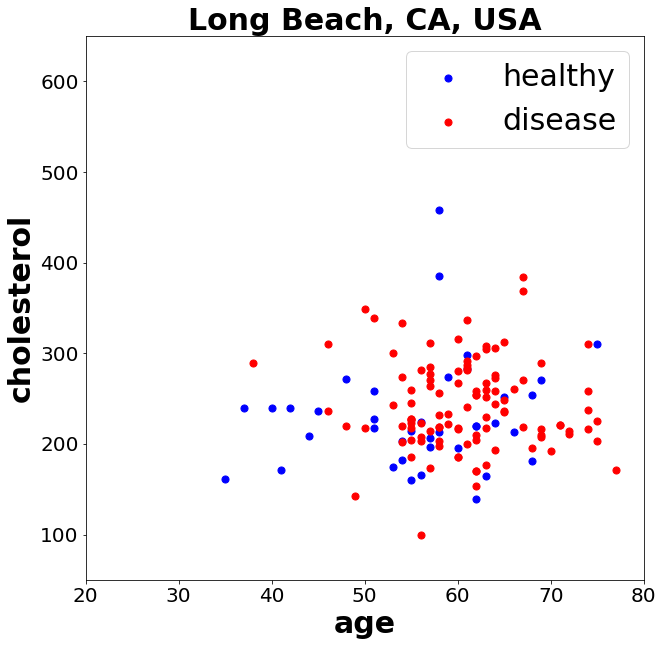

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(Z0[u==0], Z1[u==0], s=50, c='b', label='healthy')
ax.scatter(Z0[u==1], Z1[u==1], s=50, c='r', label='disease')

ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_xlim(age_lim)

ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)
ax.set_ylim(chol_lim)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_nN.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_nN.eps', bbox_inches='tight', padding='none')

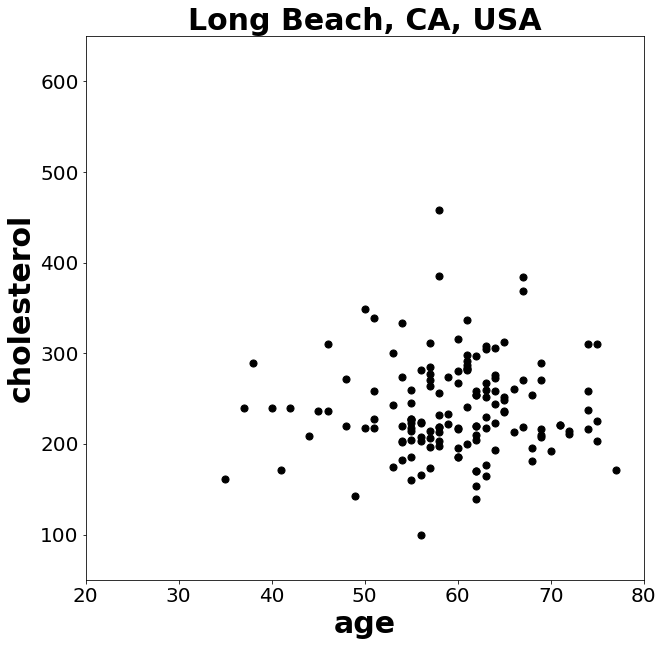

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(Z0[u==0], Z1[u==0], s=50, c='k', marker='o', label='healthy')
ax.scatter(Z0[u==1], Z1[u==1], s=50, c='k', marker='o', label='disease')

# ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_xlim(age_lim)

ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)
ax.set_ylim(chol_lim)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_nN_bw.png', bbox_inches='tight', padding='none')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


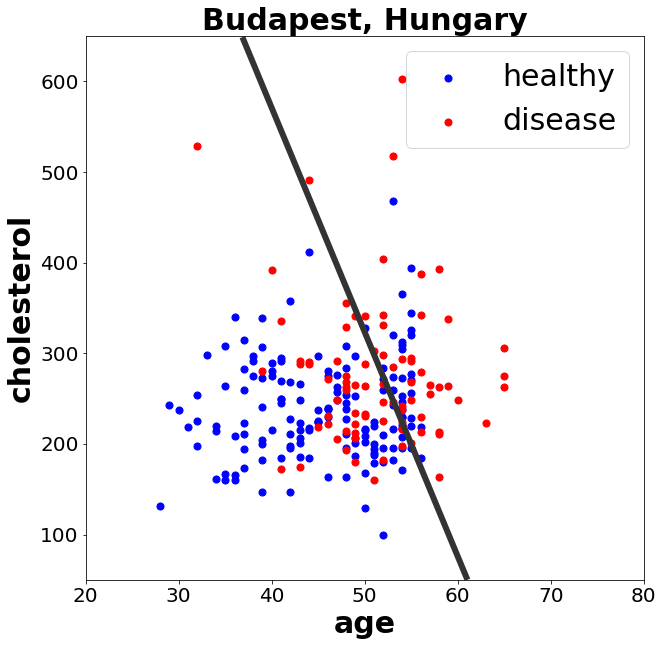

In [11]:
# Train classifier
clfN = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.0).fit(XX, yy)

# Make predictions
probsN = clfN.predict_proba(grid)[:, 1].reshape(tx.shape)

A = np.vstack((np.vstack((X0[y==0][:168], X1[y==0][:168])).T, np.vstack((X0[y==1][18:], X1[y==1][18:])).T))
b = np.hstack((np.zeros((168,)), np.ones(88,)))

# Train classifier
clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.0).fit(A, b)

# Make predictions
probsN = clf.predict_proba(grid)[:, 1].reshape(tx.shape)


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(XX[yy==0,0], XX[yy==0,1], s=50, c='b', label='healthy')
ax.scatter(XX[yy==1,0], XX[yy==1,1], s=50, c='r', label='disease')

ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)

ax.set_title(hospX, fontsize=fontsize, fontweight=fontweight)

ax.set_xlim(age_lim)
ax.set_ylim(chol_lim)

# Plot decision boundary
ax.contour(tx, ty, probsN, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='-')

fig.savefig(write_dir + 'hdis_' + hospX_ + '_age-chol_n256_dboundary.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospX_ + '_age-chol_n256_dboundary.eps', bbox_inches='tight', padding='none')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


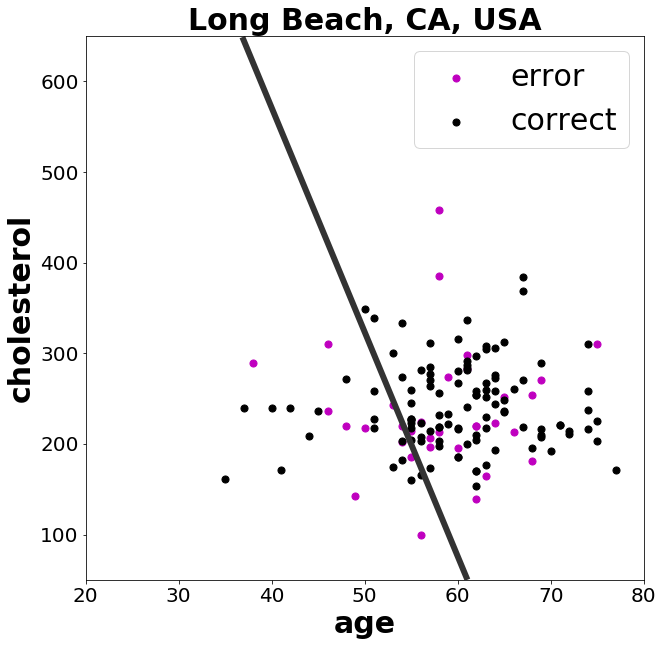

In [12]:
preds = (clfN.predict(ZZ)).astype('uint8')
correct = (preds == u).astype('uint8')

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(Z0[correct==0], Z1[correct==0], s=50, c='m', label='error')
ax.scatter(Z0[correct==1], Z1[correct==1], s=50, c='k', label='correct')

ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_xlim(age_lim)

ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)
ax.set_ylim(chol_lim)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

# Plot decision boundary
ax.contour(tx, ty, probsN, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='-')

fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_nN_preds_bw.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_nN_errors_bw.eps', bbox_inches='tight', padding='none')


In [13]:
# Train classifier
clf = TargetContrastivePessimisticClassifier(loss='lda', l2=10, tolerance=1e-100, learning_rate=10000., rate_decay='exponential')
clf.fit(XX, yy, ZZ)

Starting TCP optimization
Iteration 1/500, TCP Risk = -1.9602258881220767
Broke at iteration 2, TCP Risk = -1.9602258881220767


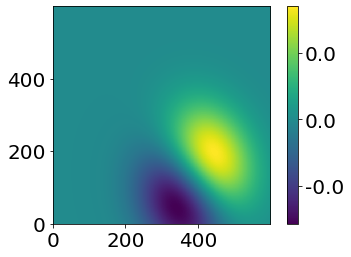

In [14]:
# Make predictions
probs = clf.predict_proba(grid)
probs = np.exp(-probs)

probs = (probs[:,1] - probs[:,0]).reshape(tx.shape)

plt.imshow(probs.T, origin='lower'); plt.colorbar(format="%.1f")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


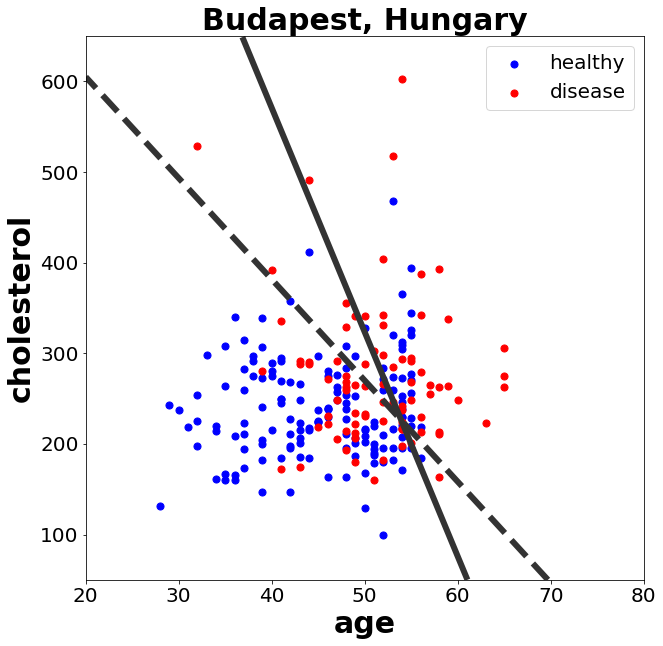

In [15]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(XX[yy==0,0], XX[yy==0,1], s=50, c='b', label='healthy')
ax.scatter(XX[yy==1,0], XX[yy==1,1], s=50, c='r', label='disease')

ax.legend(fontsize=fontsize-10)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)

ax.set_title(hospX, fontsize=fontsize, fontweight=fontweight)

ax.set_xlim(age_lim)
ax.set_ylim(chol_lim)

# Plot decision boundary
ax.contour(tx, ty, probsN, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='-')
ax.contour(tx, ty, probs, levels=[.0], cmap="Greys", vmin=-1, vmax=.2, linewidths=6, linestyles='--')

fig.savefig(write_dir + 'hdis_' + hospX_ + '_age-chol_n256_tcpr_dboundary.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospX_ + '_age-chol_n256_tcpr_dboundary.eps', bbox_inches='tight', padding='none')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


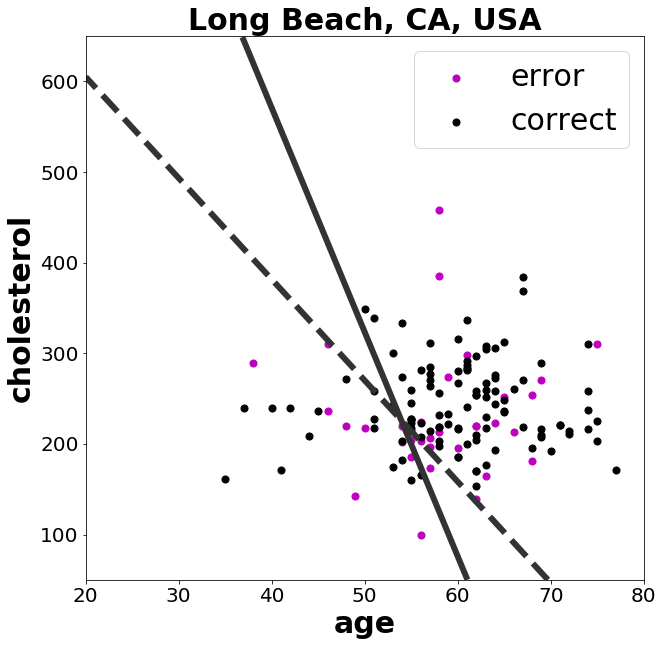

In [16]:
predsZ = clf.predict(ZZ)
correct = (predsZ == u)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))

ax.scatter(Z0[~correct], Z1[~correct], s=50, c='m', label='error')
ax.scatter(Z0[correct], Z1[correct], s=50, c='k', label='correct')

ax.legend(fontsize=fontsize)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_xlim(age_lim)

ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)
ax.set_ylim(chol_lim)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

# Plot decision boundary
ax.contour(tx, ty, probsN, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='-')
ax.contour(tx, ty, probs, levels=[.0], cmap="Greys", vmin=-1, vmax=.2, linewidths=6, linestyles='--')
# ax.contour(tx, ty, preds, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='--')

fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_nN_tcpr_correct.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_nN_tcpr_correct.eps', bbox_inches='tight', padding='none')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


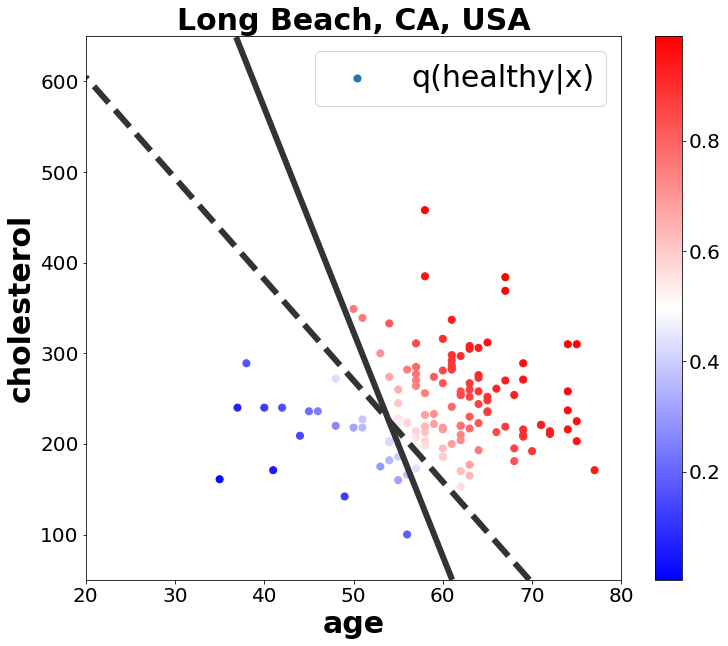

In [17]:
predsZ = clf.predict(ZZ)
correct = (predsZ == u)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,10))

post_probs = clf.predict_proba(ZZ)
post_probs = post_probs / np.sum(post_probs, axis=1)[:, np.newaxis]

im = ax.scatter(ZZ[:,0], ZZ[:,1], s=50, c=post_probs[:,0], cmap='bwr', label='q(healthy|x)')

ax.legend(fontsize=fontsize, loc=1)

ax.set_xlabel('age', fontsize=fontsize, fontweight=fontweight)
ax.set_xlim(age_lim)

ax.set_ylabel('cholesterol', fontsize=fontsize, fontweight=fontweight)
ax.set_ylim(chol_lim)

ax.set_title(hospZ, fontsize=fontsize, fontweight=fontweight)

# Plot decision boundary
ax.contour(tx, ty, probsN, levels=[.5], cmap="Greys", vmin=0, vmax=.6, linewidths=6, linestyles='-')
ax.contour(tx, ty, probs, levels=[.0], cmap="Greys", vmin=-1, vmax=.2, linewidths=6, linestyles='--')
plt.colorbar(im, ax=ax, cmap='bwr', format= "%.1f")

fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_nN_tcpr_post-probs.png', bbox_inches='tight', padding='none')
fig.savefig(write_dir + 'hdis_' + hospZ_ + '_age-chol_nN_tcpr_post-probs.eps', bbox_inches='tight', padding='none')
